In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from PIL import Image
import subprocess
from itertools import chain
import skimage
from skimage import io
import sklearn
from scipy.ndimage import gaussian_filter

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(all_xray_df.shape)
all_xray_df.sample(3)


(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
68876,00016987_016.png,Effusion,16,16987,52,M,AP,2500,2048,0.168,0.168,NaN
23222,00006148_000.png,No Finding,0,6148,57,M,PA,2500,2048,0.171,0.171,NaN
32822,00008589_000.png,No Finding,0,8589,37,F,PA,2048,2500,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print(sample_df.shape)
sample_df.sample(3)

(5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1473,00007670_002.png,Pneumothorax,2,7670,046Y,F,AP,2500,2048,0.168,0.168
4187,00020524_008.png,No Finding,8,20524,047Y,F,PA,2482,2653,0.143,0.143
1421,00007372_000.png,No Finding,0,7372,036Y,F,PA,2048,2500,0.168,0.168


# EDA

In [4]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
10485,00002718_004.png,Consolidation,4,2718,80,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20449,00005467_004.png,No Finding,4,5467,67,F,PA,2642,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
73903,00018182_000.png,Infiltration,0,18182,32,F,PA,2650,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Count the occurrence of each unique value in "Finding Labels":
all_xray_df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [6]:
# This will give you a frequency count of each unique value in the column.
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

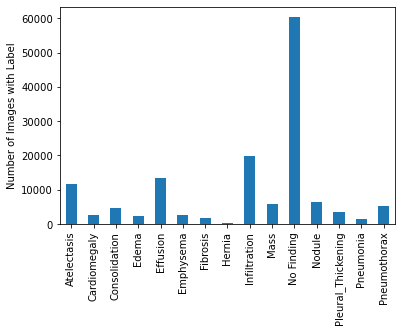

In [7]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. ***'No Finding'*** can never appear with any other label by definition, so we know that in ***53.8%*** of this dataset, there is no finding in the image. Beyond that, it appears that ***'Infiltration'*** is the most common disease-related label, and it is followed by ***'Effusion'*** and ***'Atelectasis.'***

Since ***'Infiltration'*** is the most common, I'm going to now look at how frequently it appears with all of the other diseases: 

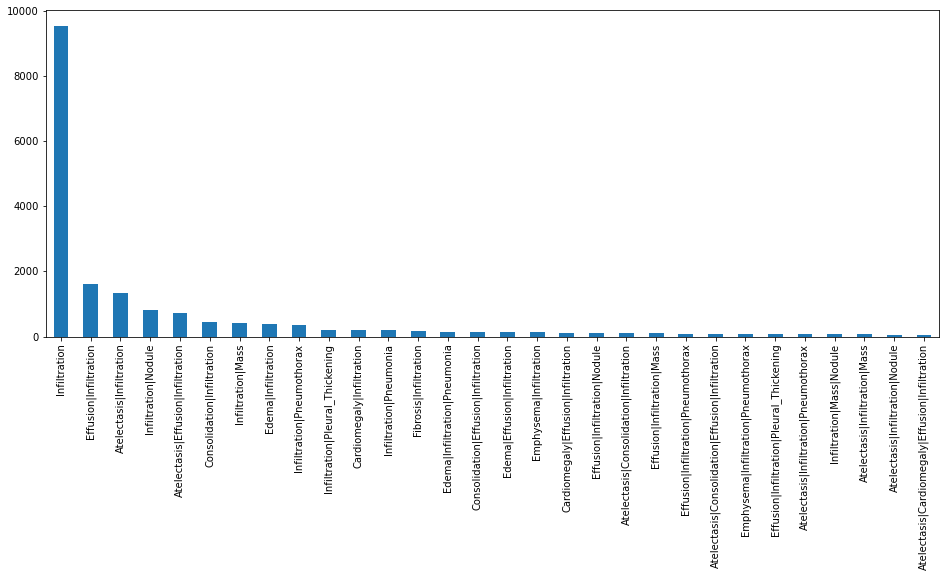

In [8]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like ***Infiltration actually occurs alone*** for the most part, and that its most-common comorbidities are Atelectasis and Effusion. 

Let's see if the same is true for another label, we'll try Effusion:

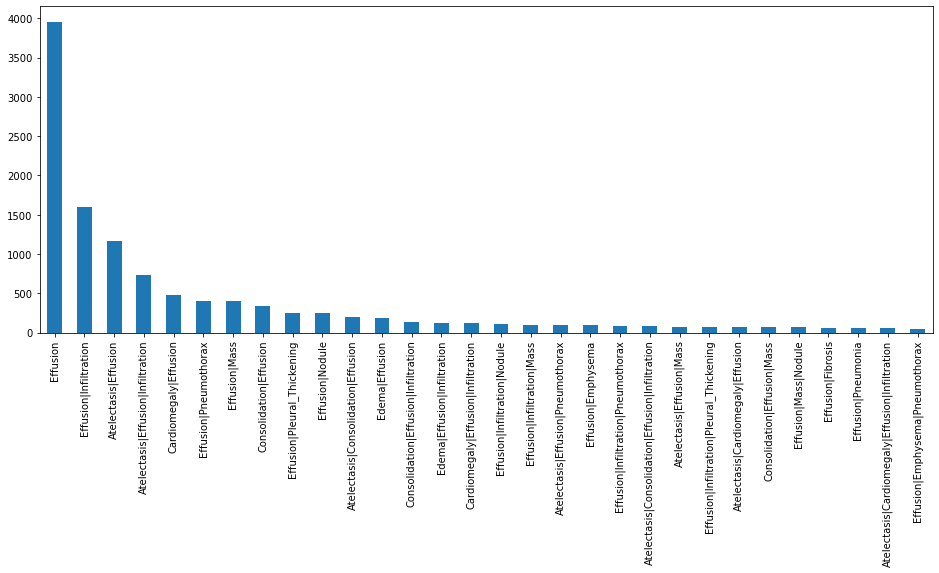

In [9]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Effusion==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Same thing! Now let's move on to looking at age & gender: 

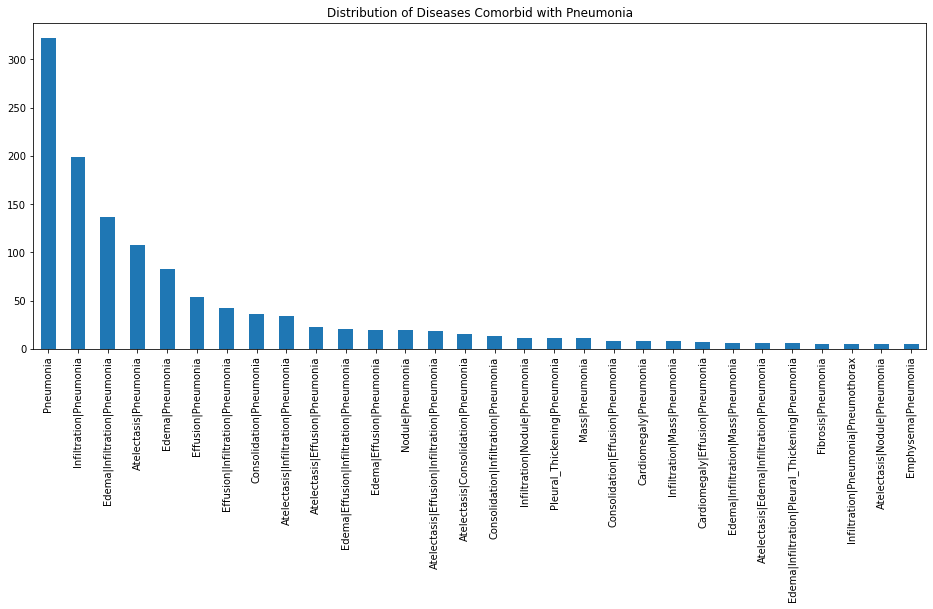

In [10]:
#'Distribution of Diseases Comorbid with Pneumonia'
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
plt.title('Distribution of Diseases Comorbid with Pneumonia')
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

# EDA - Demographic data 

In [11]:
# The patient demographic data such as gender, age, patient position,etc. (as it is available)
print("================ patient demographic data ==================")
print("\nGender Distribution: ")
print(all_xray_df['Patient Gender'].value_counts())

print("\nAge Distribution: ")
print(all_xray_df['Patient Age'].value_counts())

print("\nView poisition Distribution: ")
print(all_xray_df['View Position'].value_counts())


================ patient demographic data ==================

Gender Distribution: 
M    63340
F    48780
Name: Patient Gender, dtype: int64

Age Distribution: 
58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
411       1
413       1
414       1
95        1
152       1
Name: Patient Age, Length: 107, dtype: int64

View poisition Distribution: 
PA    67310
AP    44810
Name: View Position, dtype: int64


(array([63340.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

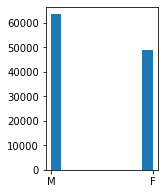

In [12]:
# Gender
plt.figure(figsize=(2,3))
plt.hist(all_xray_df['Patient Gender'])

(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

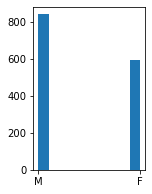

In [13]:
# Gender vs. Pneumonia
plt.figure(figsize=(2,3))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'])

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

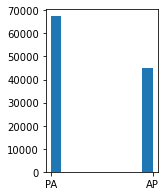

In [14]:
# VP 
plt.figure(figsize=(2,3))
plt.hist(all_xray_df['View Position'])

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

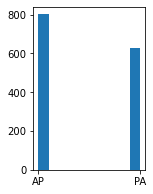

In [15]:
# VP vs. Pneumonia
plt.figure(figsize=(2,3))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['View Position'])

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

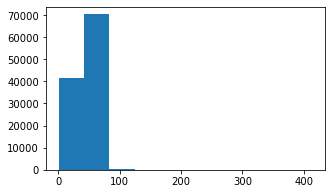

In [16]:
# Patient Age 
plt.figure(figsize=(5,3))
plt.hist(all_xray_df['Patient Age'])

It seems like there is a noisy data in the dataset. Let's only show the age under 120. 

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

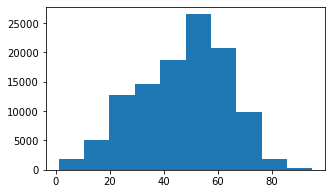

In [17]:
# Patient Age 
# Extracting ages between 0 and 120
plt.figure(figsize=(5,3))
plt.hist(all_xray_df['Patient Age'][(all_xray_df['Patient Age'] <= 120)])

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

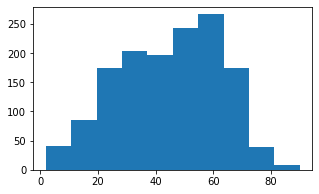

In [18]:
# Patient Age vs. Pneumonia
# Patient age distribution with Peumonia
plt.figure(figsize=(5,3))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'][all_xray_df['Patient Age'] <= 120])

(array([ 429.,  929., 2215., 2866., 3298., 3979., 4015., 1698.,  405.,
          57.]),
 array([ 1. , 10.3, 19.6, 28.9, 38.2, 47.5, 56.8, 66.1, 75.4, 84.7, 94. ]),
 <a list of 10 Patch objects>)

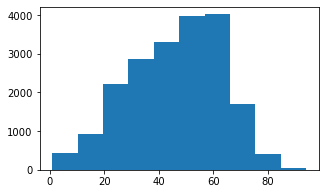

In [19]:
# Patient Age vs. Infiltration
plt.figure(figsize=(5,3))
plt.hist(all_xray_df[all_xray_df.Infiltration==1]['Patient Age'][all_xray_df['Patient Age'] <= 120])

(array([ 131.,  454., 1070., 1685., 1925., 2860., 3325., 1396.,  411.,
          59.]),
 array([ 1. , 10.3, 19.6, 28.9, 38.2, 47.5, 56.8, 66.1, 75.4, 84.7, 94. ]),
 <a list of 10 Patch objects>)

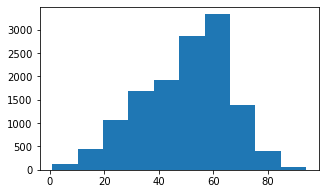

In [20]:
# Patient Age vs. Effusion
plt.figure(figsize=(5,3))
plt.hist(all_xray_df[all_xray_df.Effusion==1]['Patient Age'][all_xray_df['Patient Age'] <= 120])

In [21]:
# Number of Cases:
print("================ Number of Cases ==================")
print("\n* Number of Pneumonia Cases: ")
pneumonia_cases = len(all_xray_df[all_xray_df.Pneumonia == 1])
print(len(all_xray_df[all_xray_df.Pneumonia == 1]))

print("\n* Number of Non-Pneumonia Cases: ")
non_pneumonia_cases = len(all_xray_df) - pneumonia_cases
print(non_pneumonia_cases)

print("\n* Distribution of Other Diseases Comorbid with Pneumonia: ")
print(all_labels)

#Number of Diseases per Patient:
print("\n* Number of Diseases per Patient: ")
all_xray_df['Disease Count'] = all_xray_df['Finding Labels'].str.split('|').apply(len)
disease_per_patient = all_xray_df.groupby('Patient ID')['Disease Count'].sum()
print(disease_per_patient)

================ Number of Cases ==================

* Number of Pneumonia Cases: 
1431

* Number of Non-Pneumonia Cases: 
110689

* Distribution of Other Diseases Comorbid with Pneumonia: 
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

* Number of Diseases per Patient: 
Patient ID
1        5
2        1
3        9
4        2
5        9
        ..
30801    3
30802    1
30803    1
30804    1
30805    1
Name: Disease Count, Length: 30805, dtype: int64


#### Conclusion

Pneumonia cases are rare compared to non-pneumonia cases. We need to be careful in setting the appropriate proportion of positive and negative cases for training and validation.
- Number of Pneumonia Cases: 1431
- Number of Non-Pneumonia Cases: 110689

The training data consists of image pixels, not demographic data. However, demographic data is important for FDA submission.

# EDA - Images

Images with Pneumonia


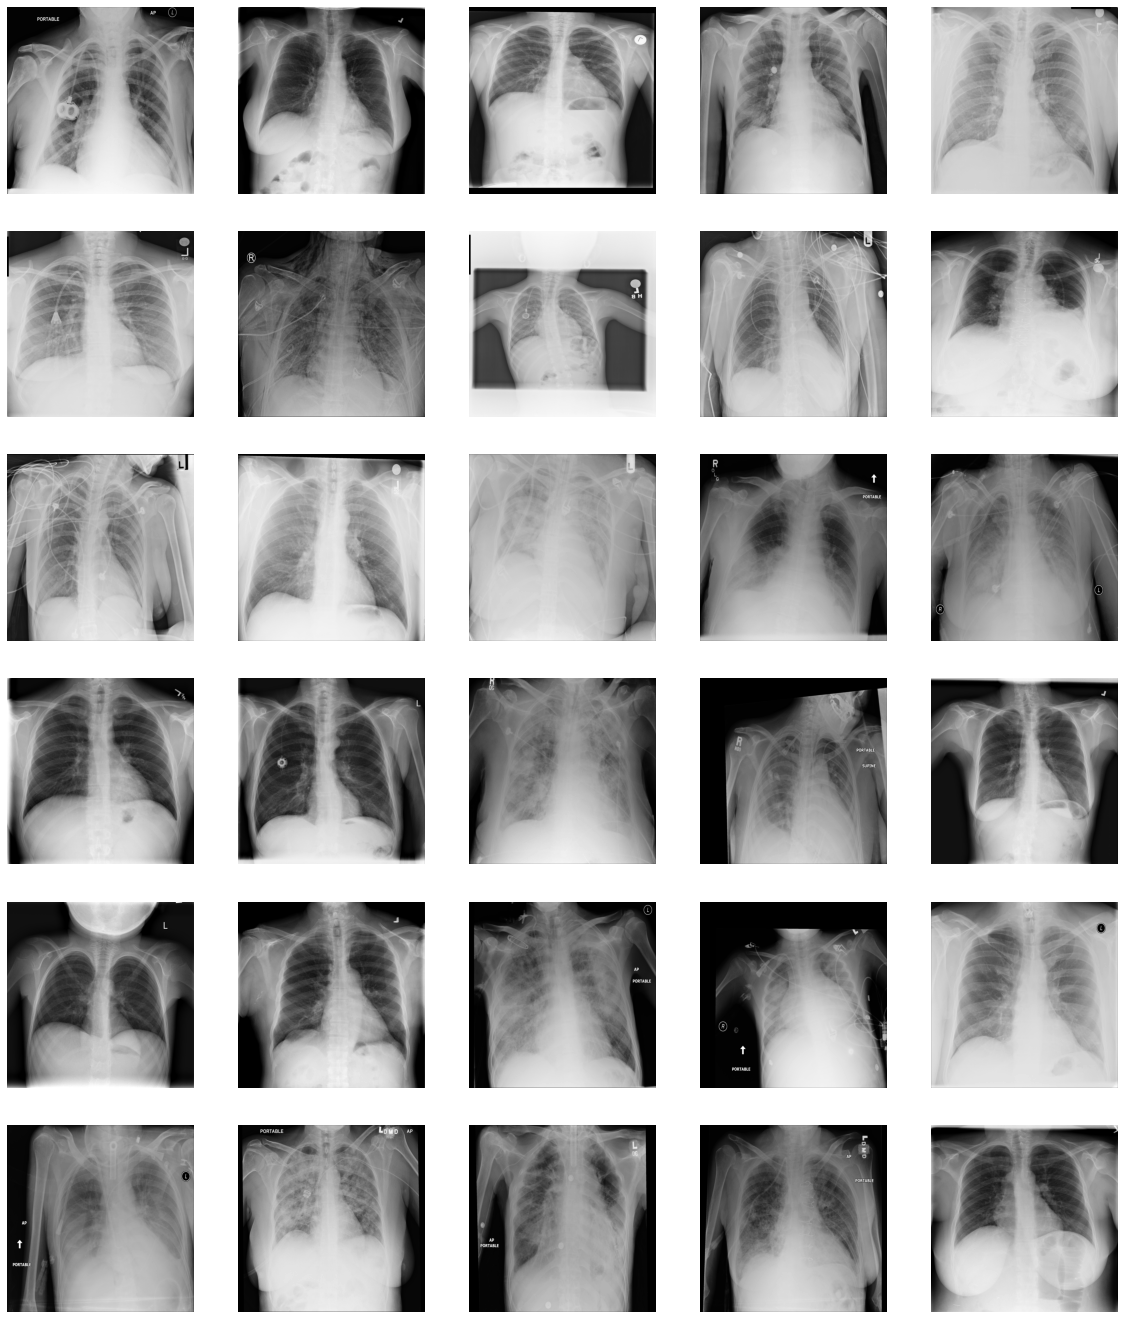

In [22]:
# Select 5 images with pneumonia
sample_df['Pneumonia'] = sample_df['Finding Labels'].str.contains('Pneumonia')
pneumonia_images = sample_df[sample_df['Pneumonia']]['Image Index'].tolist()

pneumonia_images_path = []
for pneumonia_image in pneumonia_images:
    # Construct the shell command
    cmd = f"find /data/image* -name {pneumonia_image}"
    # Run the command and capture the output
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    # Append the output (path) to the list, strip() is used to remove any newlines
    pneumonia_images_path.append(result.stdout.strip())


# Select 5 images without pneumonia
non_pneumonia_images = sample_df[~sample_df['Pneumonia']]['Image Index'].sample(100).tolist()

non_pneumonia_images_path = []
for non_pneumonia_image in non_pneumonia_images:
    # Construct the shell command
    cmd = f"find /data/image* -name {non_pneumonia_image}"
    # Run the command and capture the output
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    # Append the output (path) to the list, strip() is used to remove any newlines
    non_pneumonia_images_path.append(result.stdout.strip())

def display_images(image_paths, title):
    # Determine number of rows required for given number of images
    num_rows = -(-len(image_paths) // 5)  # Ceiling division
    
    fig, axs = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    
    # If there's only one row, axs will be a 1D array, so we reshape it for consistency
    if num_rows == 1:
        axs = axs.reshape(1, -1)
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    
    # Fill in any remaining subplots (in case there's less than 5 images in the last row)
    for ax in axs.ravel()[len(image_paths):]:
        ax.axis('off')

# Display
print("Images with Pneumonia")
display_images(pneumonia_images_path[:30], "Images with Pneumonia")


Images without Pneumonia


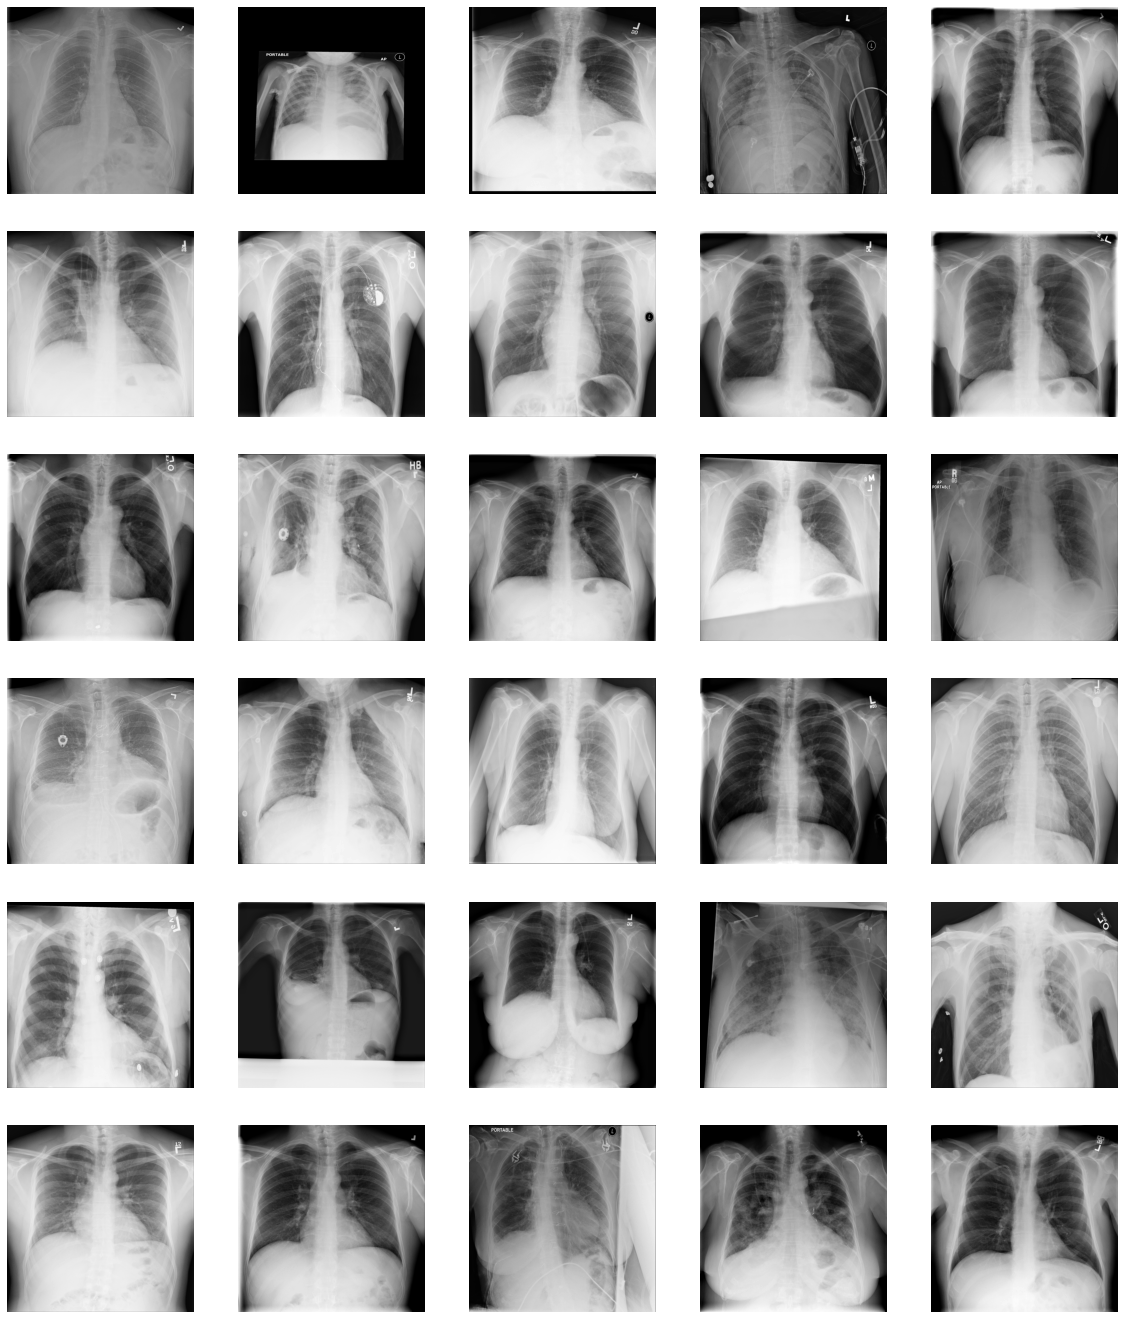

In [23]:
print("Images without Pneumonia")
display_images(non_pneumonia_images_path[:30], "Images without Pneumonia")

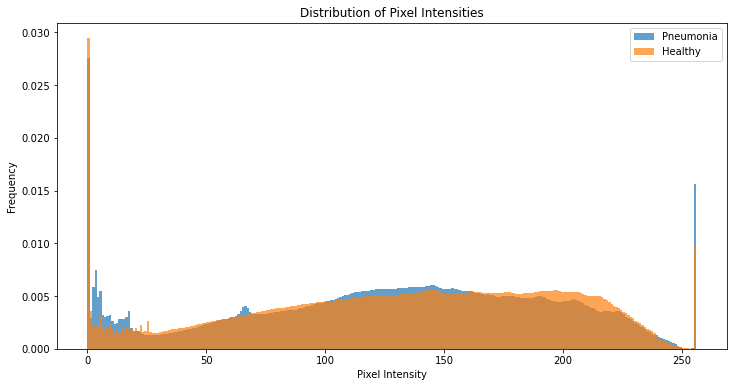

In [24]:
def get_pixel_values(image_path):
    """Returns the pixel values of an image."""
    with Image.open(image_path) as img:
        return np.array(img).flatten()

def plot_histogram(pixel_values, label):
    """Plots a histogram of pixel values."""
    plt.hist(pixel_values, bins=256, range=(0,256), density=True, alpha=0.7, label=label)

# Sample pixel values for pneumonia and healthy images
pneumonia_pixels = [get_pixel_values(img) for img in pneumonia_images_path]
non_pneumonia_pixels = [get_pixel_values(img) for img in non_pneumonia_images_path]

# Plotting the histograms
plt.figure(figsize=(12, 6))

# Aggregate pixel values from multiple images if needed and then plot
plot_histogram(np.concatenate(pneumonia_pixels), 'Pneumonia')
plot_histogram(np.concatenate(non_pneumonia_pixels), 'Healthy')

plt.legend()
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Intensities')
plt.show()

### EDA-Images with filtering background

In [25]:
img_p = io.imread(pneumonia_images_path[0])
img_n = io.imread(non_pneumonia_images_path[0])

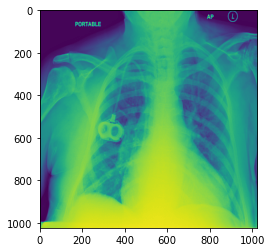

In [28]:
plt.imshow(img_p)


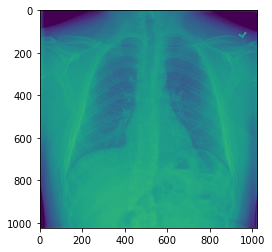

In [27]:
plt.imshow(img_n)

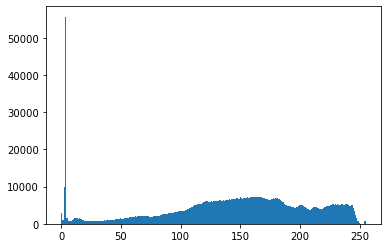

In [29]:
x = plt.hist(img_p.ravel(),bins=256)

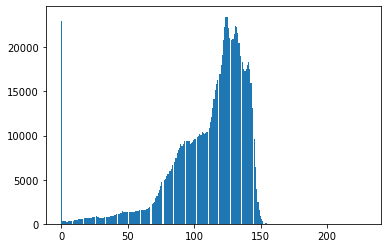

In [30]:
x = plt.hist(img_n.ravel(),bins=256)

In [41]:
thresh = 50

img_p_bin = (img_p > thresh) * 255
img_n_bin = (img_n > thresh) * 255

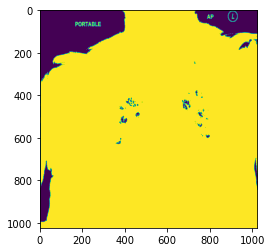

In [42]:
plt.imshow(img_p_bin)

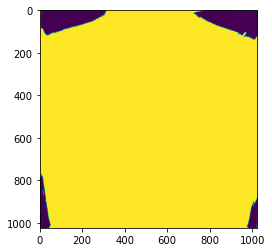

In [43]:
plt.imshow(img_n_bin)

In [58]:
img_p_intensities = []
low_thresh = 50
upper_thresh = 230

for path in pneumonia_images_path: 
    img = io.imread(path)
    img_mask = (img > low_thresh) & (img < upper_thresh)
    img_p_intensities.extend(img[img_mask].tolist())

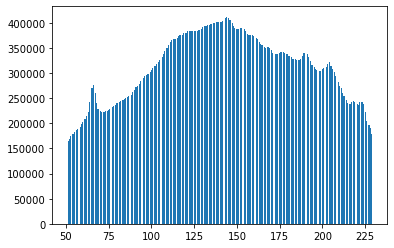

In [59]:
x = plt.hist(img_p_intensities,bins=256)

In [65]:
img_n_intensities = []

for path in non_pneumonia_images_path: 
    img = io.imread(path)
    img_mask = (img > low_thresh) & (img < upper_thresh)
    img_n_intensities.extend(img[img_mask].tolist())

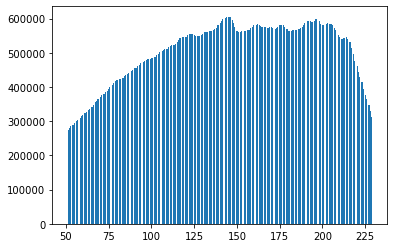

In [66]:
x = plt.hist(img_n_intensities,bins=256)

In [67]:
import scipy

scipy.stats.mode(img_p_intensities)[0][0]

144

In [68]:
scipy.stats.mode(img_n_intensities)[0][0]

145

#### Conclusion
From the X-ray, we can interpret that a lung with pneumonia has white spots (called infiltrates) that indicate an infection. As we can see from the distributions of intensity values of the pixel-level data within images, a lung with pneumonia has more pixels in the range of 125-150, whereas a lung without pneumonia has a plateau peak at 150-200. This suggests that a lung with pneumonia has more bright pixels, which might be caused by white spots.